In [1]:
import os 
from generator import Generator

from keras.models import Sequential 
from keras.layers import Flatten, Dense, Dropout, Cropping2D, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras import losses, optimizers, metrics, backend, regularizers 
from keras.constraints import maxnorm
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.layers.normalization import BatchNormalization

def resize(img):
    from keras.backend import tf as ktf
    return ktf.image.resize_images(img, [90, 160])

Using TensorFlow backend.


In [2]:
def build_model(drop_prob = 0.2, learn_rate=0.001, constraint=maxnorm(3), reg = None, verbose = False): 
    backend.clear_session()
    model = Sequential()

    ###--- Convolutional Neural Network --- ### 
    input_shape = (180, 320, 3)

    model.add(Cropping2D(cropping=((60, 0), (0, 0)), input_shape=input_shape))
    # model.add(Lambda(resize, input_shape=input_shape))
    model.add(BatchNormalization(name='r0'))

    ### conv. layers 
    model.add(Convolution2D(filters=24,
                            kernel_size=(5, 5),
                            strides = (2, 2),
                            activation='relu',
                            kernel_regularizer=reg, 
                            input_shape=input_shape, 
                            ))
    '''READ THIS try adding max pool - before min loss was 7.04'''
#     model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization(name='r1'))

    model.add(Convolution2D(filters=36,
                            kernel_size=(5, 5),
                            strides = (2, 2),
                            activation='relu',
                            kernel_regularizer=reg, 
                            ))
    model.add(BatchNormalization(name='r2'))

    model.add(Convolution2D(filters=48,
                            kernel_size=(5, 5),
                            strides = (2, 2),
                            activation='relu',
                            kernel_regularizer=reg, 
                            ))
    model.add(BatchNormalization(name='r3'))

    model.add(Convolution2D(filters=64,
                            kernel_size=(3, 3),
                            strides = (1, 1),
                            activation='relu',
                            kernel_regularizer=reg, 
                            ))
    model.add(BatchNormalization(name='r4'))

    model.add(Convolution2D(filters=64,
                            kernel_size=(1, 1),
                            strides = (2, 2),
                            activation='relu',
                            kernel_regularizer=reg, 
                            ))
    model.add(BatchNormalization(name='r5'))

    ### fully connect layers 
    model.add(Flatten())
    model.add(Dense(1164, activation='relu', kernel_constraint=constraint))
    model.add(Dropout(drop_prob))

    model.add(Dense(100, activation='relu', kernel_constraint=constraint))
    model.add(Dropout(drop_prob))

    model.add(Dense(50, activation='relu', kernel_constraint=constraint))
    model.add(Dropout(drop_prob))

    model.add(Dense(10, activation='relu', kernel_constraint=constraint))
    model.add(Dropout(drop_prob))

    model.add(Dense(1, activation='linear'))

    if verbose: 
        # Summarize the model
        model.summary()
    
    #compile 
    model.compile(loss='mse', optimizer=optimizers.Adam(lr=learn_rate))

    return model 

### Callbacks 

In [3]:
#tensorboard object 
!mkdir logs
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)

#save and overwrite models when improved 
filepath="checkpoints/baseline_best.h5"

!mkdir checkpoints
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=0, mode='auto')

callbacks_list = [checkpoint, tensorboard]

mkdir: cannot create directory ‘logs’: File exists
mkdir: cannot create directory ‘checkpoints’: File exists


### Build Model 

In [4]:
BATCH_SIZE = 512
EPOCHS = 20
LEARN_RATE = 0.001
DROP_PROB = 0.4

control_model = build_model(drop_prob = DROP_PROB, learn_rate = LEARN_RATE, verbose=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 120, 320, 3)       0         
_________________________________________________________________
r0 (BatchNormalization)      (None, 120, 320, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 158, 24)       1824      
_________________________________________________________________
r1 (BatchNormalization)      (None, 58, 158, 24)       96        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 77, 36)        21636     
_________________________________________________________________
r2 (BatchNormalization)      (None, 27, 77, 36)        144       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 37, 48)        43248     
__________

### Init Data

In [5]:
RUN = 'floyd' # (str) local or floyd 

#select data directories 
if RUN == 'local':  
    train_dir = os.path.join('..', 'data', 'train')
    val_dir = os.path.join('..', 'data', 'validation')
elif RUN == 'floyd':
    train_dir = os.path.join('/input', 'train')
    val_dir = os.path.join('/input', 'validation')
else: 
    print('not a valid directory')
    
#init data generators 
train_gen = Generator(train_dir, batch_size = BATCH_SIZE, normalize = True, SVD = False, flip=True, yuv=True)
val_gen = Generator(val_dir, batch_size = BATCH_SIZE, normalize = True, SVD = False, flip=False, yuv=True)

#optionally train on a subset of the data (check for 0 cost) 
train_gen.img_dir = train_gen.img_dir[:]
val_gen.img_dir = val_gen.img_dir[:]

### Fit Baseline/Control Model 

In [6]:
#fit 
control_hist = control_model.fit_generator(generator = train_gen,
                           steps_per_epoch = len(train_gen.img_dir)//train_gen.batch_size,
                           validation_data = val_gen,
                           validation_steps = len(val_gen.img_dir)//val_gen.batch_size, 
                           epochs = EPOCHS,
                           callbacks = callbacks_list,
                           verbose = 1)

#save final model
control_model.save('baseline.h5')

Epoch 1/20
36/36 [==============================] - 142s - loss: 21.9892 - val_loss: 11.4188
Epoch 2/20
36/36 [==============================] - 57s - loss: 12.2734 - val_loss: 9.9326
Epoch 3/20
36/36 [==============================] - 57s - loss: 9.0497 - val_loss: 9.6368
Epoch 4/20
36/36 [==============================] - 57s - loss: 7.3600 - val_loss: 9.6050
Epoch 5/20
36/36 [==============================] - 57s - loss: 6.8978 - val_loss: 9.1117
Epoch 6/20
36/36 [==============================] - 57s - loss: 6.4784 - val_loss: 9.2409
Epoch 7/20
36/36 [==============================] - 57s - loss: 6.2712 - val_loss: 8.8623
Epoch 8/20
36/36 [==============================] - 57s - loss: 6.2141 - val_loss: 9.0665
Epoch 9/20
36/36 [==============================] - 57s - loss: 5.8926 - val_loss: 8.6027
Epoch 10/20
36/36 [==============================] - 57s - loss: 5.7475 - val_loss: 8.0395
Epoch 11/20
36/36 [==============================] - 57s - loss: 5.6827 - val_loss: 7.5871
Epoc

### Fit SVD Model

Using exact same hyperparameters as Baseline Control Model.

In [12]:
SVD_model = build_model(drop_prob = DROP_PROB, learn_rate = LEARN_RATE, verbose=0)

#init data generators 
train_gen = Generator(train_dir, batch_size = BATCH_SIZE, normalize = True, SVD = True, flip=False, yuv=True)
val_gen = Generator(val_dir, batch_size = BATCH_SIZE, normalize = True, SVD = False, flip=False, yuv=True)

#fit 
SVD_hist = SVD_model.fit_generator(generator = train_gen,
                           steps_per_epoch = len(train_gen.img_dir)//train_gen.batch_size,
                           validation_data = val_gen,
                           validation_steps = len(val_gen.img_dir)//val_gen.batch_size, 
                           epochs = EPOCHS,
                           callbacks = callbacks_list,
                           verbose = 1)

#save final model
SVD_model.save('baseline.h5')

Epoch 1/20
36/36 [==============================] - 141s - loss: 18.3748 - val_loss: 11.1658
Epoch 2/20
36/36 [==============================] - 57s - loss: 10.7230 - val_loss: 10.0787
Epoch 3/20
36/36 [==============================] - 57s - loss: 8.5127 - val_loss: 9.9147
Epoch 4/20
36/36 [==============================] - 56s - loss: 7.5240 - val_loss: 9.0651
Epoch 5/20
36/36 [==============================] - 56s - loss: 6.9909 - val_loss: 9.0860
Epoch 6/20
36/36 [==============================] - 57s - loss: 6.5092 - val_loss: 9.1850
Epoch 7/20
36/36 [==============================] - 57s - loss: 6.1864 - val_loss: 10.0366
Epoch 8/20
36/36 [==============================] - 56s - loss: 6.0561 - val_loss: 20.3172
Epoch 9/20
36/36 [==============================] - 57s - loss: 5.7470 - val_loss: 24.9332
Epoch 10/20
36/36 [==============================] - 57s - loss: 5.4871 - val_loss: 24.9978
Epoch 11/20
36/36 [==============================] - 57s - loss: 5.6982 - val_loss: 27.162

### Visualize the results! 

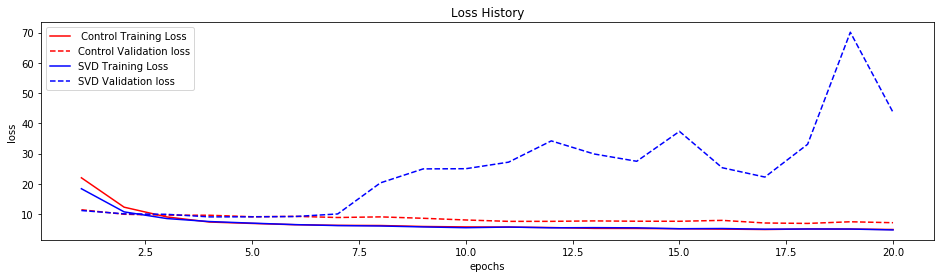

In [16]:
import matplotlib.pyplot as plt
import numpy as np

control_loss = control_hist.history['loss']
control_val_loss = control_hist.history['val_loss']
SVD_loss = SVD_hist.history['loss']
SVD_val_loss = SVD_hist.history['val_loss']

x = list(np.linspace(1, len(control_loss), len(control_loss)))

plt.figure(figsize=(16, 4))

plt.plot(x, control_loss, color = 'r', linestyle='-', label=' Control Training Loss') 
plt.plot(x, control_val_loss, color = 'r', linestyle='--', label='Control Validation loss')
plt.plot(x, SVD_loss, color = 'b', linestyle='-', label='SVD Training Loss') 
plt.plot(x, SVD_val_loss, color = 'b', linestyle='--',  label='SVD Validation loss')

plt.title('Loss History'); plt.xlabel('epochs'); plt.ylabel('loss'); 
plt.legend()
plt.show()

In [9]:
# from skimage.io import imread
# import glob 
# import numpy as np

# def rgb2gray(rgb):
#     '''cvt image from RGB to grayscale'''
#     return np.dot(rgb[:, :, :3], [0.299, 0.587, 0.114]).reshape(1,180, 320, 1)

# test_dir = glob.glob( os.path.join('/input', 'train', 'images') + '/*')
# # for file in test_dir: 
# #     truth = float(file.split('/')[-1].split('_')[-1].split('.')[0])/10
# # #     print (model.predict(rgb2gray(imread(file)))[0][0], truth)